In [1]:
import gym

import torch
import torch.nn as nn

import copy

import time
from tqdm.notebook import tqdm
import numpy as np
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline

# Deep Q-learning

In [2]:
class NN(nn.Module):
    def __init__(self, state_dim, action_n):
        super(NN, self).__init__()

        self.linear1 = nn.Linear(state_dim, 32)
        self.linear2 = nn.Linear(32, 32)
        self.linear3 = nn.Linear(32, action_n)
        self.relu = nn.ReLU(inplace=True)
            
    def forward(self, x):
        x = torch.FloatTensor(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x


class DQN():
    def __init__(self, model, action_n, batch_size, trajectory_n):
        self.model = model
        self.action_n = action_n
        self.epsilon = 1
        self.epsilon_decrease = 1 / trajectory_n
        self.memory = []
        self.batch_size = batch_size

    def get_action(self, state):

        qvalues = self.model(state).detach().numpy()
        probs = np.ones(self.action_n) * self.epsilon / self.action_n
        agrmax_action = np.argmax(qvalues)
        probs[agrmax_action] += 1 - self.epsilon
        action = np.random.choice(self.action_n, p=probs)

        return action

    def get_batch(self):
        batch = sample(population=self.memory, k=self.batch_size)

        states, actions, rewards, dones, next_states = [], [], [], [], []

        for i in range(self.batch_size):
            states.append(batch[i][0])
            actions.append(batch[i][1])
            rewards.append(batch[i][2])
            dones.append(batch[i][3])
            next_states.append(batch[i][4])

        return states, actions, rewards, dones, next_states


    def training_step(self, state, action, reward, done, next_state, gamma):
        
        self.memory.append([state, action, reward, done, next_state])
        
        if len(self.memory) > self.batch_size * 10:
            
            states, actions, rewards, dones, next_states = self.get_batch()



            q = self.model(states)
            q_next = self.model(next_states)

            targets = q.clone()

            for i in range(self.batch_size):
                targets[i][actions[i]] = rewards[i] + (1 - dones[i]) * gamma * torch.max(q_next[i])

            loss = torch.mean((targets.detach() - q) ** 2)
            self.epsilon = max(0, self.epsilon - self.epsilon_decrease)
            
            return loss
  

In [30]:
def train_dqn_hard_update(epochs, traj_per_epoch, 
                          target_agent, target_model, training_agent, training_model, 
                          env, trajectory_len, action_n, 
                          batch_size, gamma, lr, opt_f=torch.optim.SGD):


    history = {'train_rewards': [], 'train_losses': [], 'val_rewards': [], 'checkpoints': []}

    opt = opt_f(training_model.parameters(), lr=lr)
    
    for epoch in range(epochs):

        
        training_model.load_state_dict(target_model.state_dict())
        
        epoch_loss = 0
        epoch_reward = 0
                
        for traj_i in tqdm(range(traj_per_epoch)):
            
            state = env.reset()
            
            trajectory_loss = 0
            trajectory_reward = 0
            
            for _ in range(trajectory_len):
                
                action = training_agent.get_action(state)
                
                next_state, reward, done, info = env.step(action)
                
                loss = training_agent.training_step(state, action, reward, done, next_state, gamma)
                
                if loss is not None:
                    loss.backward()
                    opt.step()
                    opt.zero_grad()
                    trajectory_loss += loss
                
                trajectory_reward += reward
                state = next_state
                if done: 
                    break
            epoch_loss += trajectory_loss
            epoch_reward += trajectory_reward
        
        checkpoint = training_model.state_dict()    
        
        epoch_loss /= traj_per_epoch
        epoch_reward /= traj_per_epoch
        history['train_losses'].append(epoch_loss)
        history['train_rewards'].append(epoch_reward)
        history['checkpoints'].append(checkpoint)
        
        target_model.load_state_dict(checkpoint)
        
        for idx, (p1, p2) in enumerate(zip(target_model.named_parameters(), training_model.named_parameters())):
            if not p1[0] == p2[0]:
                print('different parameter order for idx {}'.format(idx))
            if not torch.equal(p1[1].data, p2[1].data):
                print('idx {} not equal'.format(idx))
            else:
                print('parameter {} is equal'.format(idx))
        state = env.reset()
        val_reward = 0
        for _ in range(trajectory_len):
            action = target_agent.get_action(state)
            state, reward, done, info = env.step(action)
            val_reward += reward
            if done: 
                break
        history['val_rewards'].append(val_reward)
        print(f'{epoch = } \t mean_{epoch_loss = } \t mean_{epoch_reward = } \t {val_reward = }')
    
    return history

In [31]:
env = gym.make("Acrobot-v1")


state_dim = env.observation_space.shape[0]
action_n = env.action_space.n


/home/verius00/.local/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/verius00/.local/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
epochs = 15
traj_per_epoch = 30
batch_size = 64

target_model = NN(state_dim=state_dim, action_n=action_n)
target_agent = DQN(model=target_model, action_n=action_n, batch_size=batch_size, trajectory_n=traj_per_epoch)

training_model = NN(state_dim=state_dim, action_n=action_n)
training_agent = DQN(model=training_model, action_n=action_n, batch_size=batch_size, trajectory_n=traj_per_epoch)

trajectory_len = 500

gamma = 0.99
lr = 1e-2
opt_f = torch.optim.Adam


history_hard_update = train_dqn_hard_update(epochs, traj_per_epoch, 
                                            target_agent, target_model, 
                                            training_agent, training_model,
                                            env, trajectory_len, action_n, batch_size, gamma, lr, opt_f=opt_f)

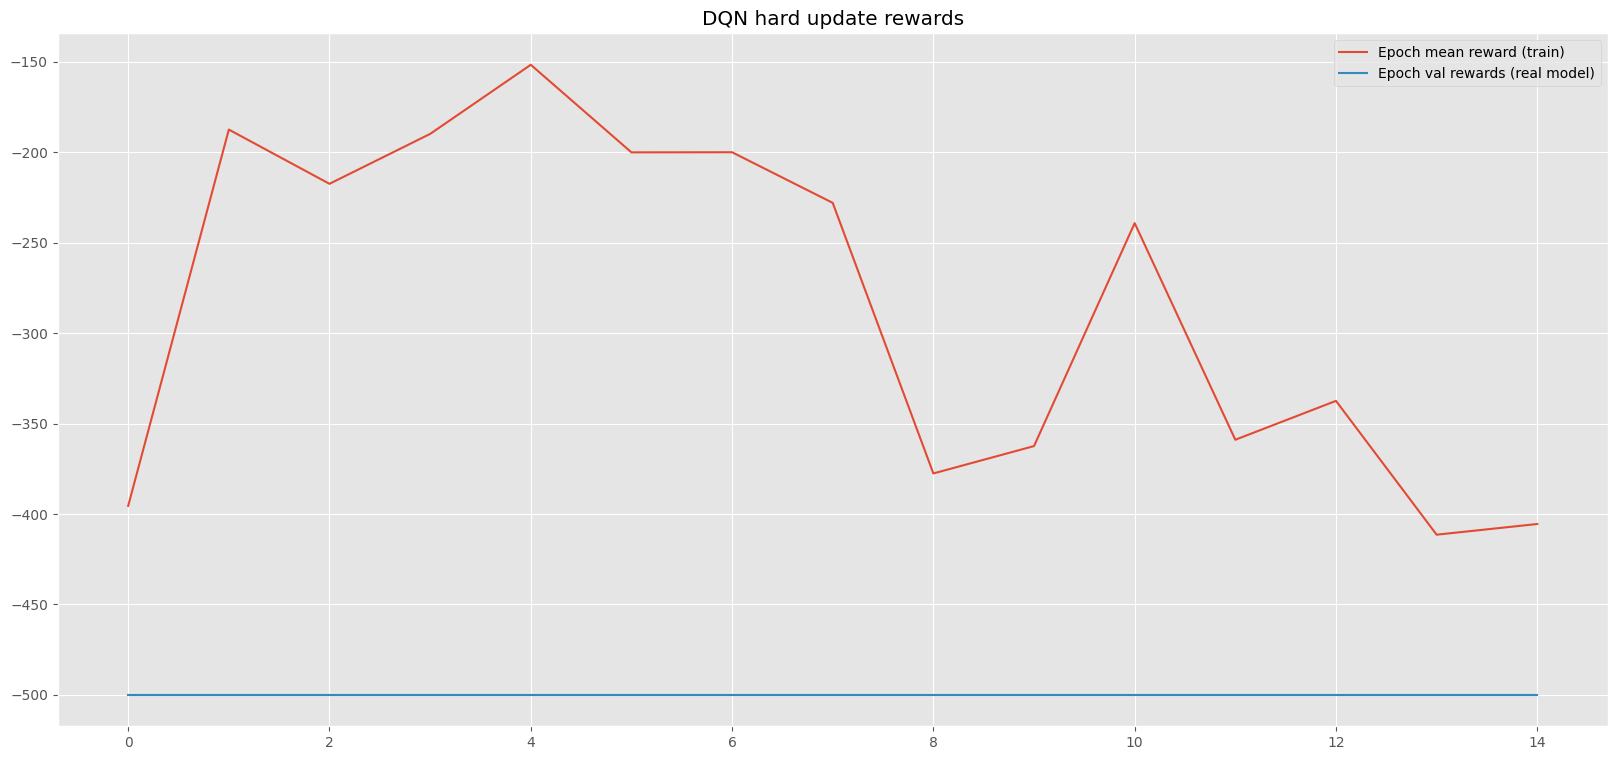

In [29]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(20, 9))
    plt.plot(history_hard_update['train_rewards'], label='Epoch mean reward (train)')
    plt.plot(history_hard_update['val_rewards'], label='Epoch val rewards (real model)')
    plt.title('DQN hard update rewards')
    plt.legend()

In [25]:
def get_trajectory(env, agent, t_len):
    state = env.reset()
    tot_reward = 0
    for _ in range(t_len):
        action = agent.get_action(state)
        state, reward, done, _ = env.step(action)
        tot_reward += reward
        if done:
            break
    return tot_reward

In [28]:
get_trajectory(env, training_agent, trajectory_len)

-500.0

[Parameter containing:
 tensor([[ -4.4013,  -1.4418,  -7.0116,  -0.6091,  -1.4794,   1.0218],
         [ -6.2576,  -6.1035,   2.7656,   2.2623,   3.9234,   3.8377],
         [  0.7427,  -0.0391, -11.9745,  -4.0187,   1.5476,   1.0910],
         [  1.2084,  -3.6869,   5.3698,   2.9982,  -3.2089,  -2.2494],
         [ -4.0763,  -6.3710,  -5.6046,  -0.8729,  -2.7364,   0.4381],
         [ -2.2271,   0.8525,  -6.5248,   1.0925,  -0.1347,   0.2209],
         [ -9.2894,   1.7340,  -2.3096,   6.1628,   2.8491,   0.5173],
         [ -0.6348,   1.1311,  -8.4993,  -3.8715,  -1.9462,   1.6023],
         [ -6.1051,  -4.9055,  -6.9993,   1.2664,  -3.3444,  -1.1980],
         [  4.5308,   6.1657,   3.0078,   2.9499,  -2.0413,   0.5225],
         [  1.7782,  -4.1141,   0.7148,  -0.9320,  -0.7258,  -3.1600],
         [ -9.6209,  -6.4182,   3.5397,  -5.4406,  -2.1181,   1.3727],
         [ 10.5987,   1.8252,  -2.2186,  -0.9286,   0.3566,   0.1784],
         [ -8.6345,  -4.3197,  -6.4514,   3.1276,   0.